In [21]:
import numpy as np
import pandas as pd
import os
import sys
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import fastcluster
from scipy.cluster.hierarchy import fcluster

In [2]:
mixing_directory = 'maester_mixing'
mixing_quality_directory = 'maester_mixing_quality_based'
bp_directory = 'maester_bpdcn'
bp_quality_directory = 'maester_bpdcn_quaity_based'

In [3]:
mixing_heteroplasmy = pd.read_csv(f'{mixing_directory}/final/final_variants_heteroplasmy_matrix.csv', index_col='variant')
mixing_quality_heteroplasmy = pd.read_csv(f'{mixing_quality_directory}/final/final_variants_heteroplasmy_matrix.csv', index_col='variant')


In [4]:
mixing_heteroplasmy

,CGTTGGGTCTATCCAT,CACACAAGTGGTCTCG,ACCCTCAGTGAGTCAG,AGAGCAGTCTTCCCAG,GGGAAGTTCACTGTTT,TCATTACCATGCCATA,CATCGCTTCGCCTTTG,GCTTTCGCATGATGCT,GTAAGTCCAGCATTGT,ATCGGATCAGCGGATA,...,TCGGATAAGGACAACC,GGGAAGTAGACATACA,TACAACGGTGTCATTG,TTACTGTGTTGTCTAG,CTGCCATGTCCCTGAG,ATGATCGAGAGCCGAT,AATGGAAAGGATATGT,TTCACCGGTACCGCGT,CCCATTGGTGAAGCTG,TATACCTCATACTGTG
variant,,,,,,,,,,,,,,,,,,,,,
8404_T_G,0.000000,0.000000,0.002849,0.003221,0.016949,0.000000,0.000000,0.000000,0.000000,0.007364,...,0.000000,0.000000,0.002299,0.000000,0.000000,0.000000,0.000000,0.004608,0.003273,0.000000
8528_T_A,0.021277,0.038128,0.042735,0.038400,0.016949,0.059322,0.022388,0.049133,0.022222,0.049927,...,0.131579,0.083333,0.050459,0.022727,0.080000,0.068965,0.034483,0.061785,0.039152,0.034483
12740_A_C,0.000000,0.000000,0.005587,0.006849,0.000000,0.000000,0.008929,0.009091,0.000000,0.000000,...,0.000000,0.000000,0.010363,0.000000,0.000000,0.000000,0.000000,0.000000,0.007435,0.000000
11171_A_G,0.000000,0.003846,0.008475,0.003521,0.000000,0.000000,0.010000,0.000000,0.000000,0.005450,...,0.000000,0.000000,0.006006,0.000000,0.000000,0.028571,0.000000,0.003333,0.010309,0.024194
8466_A_G,0.000000,0.000000,0.005698,0.004800,0.000000,0.008475,0.007463,0.002890,0.000000,0.007342,...,0.000000,0.000000,0.002294,0.000000,0.010000,0.034483,0.000000,0.002288,0.001631,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14919_A_C,0.000000,0.010417,0.000000,0.002315,0.000000,0.013514,0.000000,0.003300,0.000000,0.000000,...,0.000000,0.000000,0.005319,0.000000,0.000000,0.000000,0.025000,0.000000,0.005236,0.000000
3674_C_A,0.030303,0.031250,0.034843,0.036765,0.022222,0.033113,0.029412,0.024390,0.071428,0.045845,...,0.000000,0.090909,0.033898,0.038461,0.060606,0.000000,0.000000,0.040872,0.053763,0.030769
12704_T_A,0.038461,0.016949,0.000000,0.000000,0.000000,0.005405,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.054054,0.005181,0.000000,0.011765,0.000000,0.000000,0.006803,0.011152,0.018518


In [5]:
mixing_quality_heteroplasmy

,ACCCTTGTCTTGGTGA,CAGCACGAGCCTATCA,AGCTCAAAGCCTTTCC,GACCCTTCATCCAACA,AACGTCAAGAGGCCAT,TCGTGGGTCGCCCAGA,CGCATAAGTCACTGAT,CGGAACCCACTATCCC,TGGGTTAAGGGACAGG,CTACGGGAGAGGGCGA,...,TCGCAGGAGCTCCATA,GCTACAAGTGTTCGTA,CGCGTGACAGAGAGGG,GCAACATCAGTTTCGA,CGTTCTGGTTTCGATG,ACACAGTCAGCTCGGT,AAAGGTACAGGGACTA,ATCTTCATCCATCAGA,AGGCTGCCAATGCAAA,GTGCACGCAGAGGTAC
variant,,,,,,,,,,,,,,,,,,,,,
8510_A_T,0.004926,0.010638,0.003521,0.000000,0.005000,0.000000,0.002747,0.000000,0.000000,0.005312,...,0.011765,0.013333,0.004601,0.000000,0.006873,0.000000,0.009174,0.007812,0.008772,0.000000
1597_C_G,0.009756,0.006250,0.003279,0.000000,0.000000,0.009091,0.003390,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.003279,0.000000,0.000000,0.008197,0.000000,0.007812,0.000000
8484_A_C,0.000000,0.000000,0.003521,0.000000,0.001669,0.000000,0.002747,0.000000,0.013513,0.002656,...,0.000000,0.013333,0.000000,0.016393,0.006873,0.000000,0.000000,0.000000,0.000000,0.002817
12523_A_G,0.000000,0.000000,0.000000,0.000000,0.004630,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1562_G_T,0.013514,0.016304,0.020528,0.000000,0.031111,0.023622,0.003086,0.000000,0.007246,0.011204,...,0.015504,0.011236,0.016260,0.008721,0.021834,0.000000,0.007143,0.000000,0.000000,0.005900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12605_T_A,0.088495,0.076923,0.057971,0.055555,0.062500,0.052631,0.039683,0.000000,0.086956,0.078358,...,0.066667,0.000000,0.084158,0.081081,0.042553,0.086956,0.048780,0.041667,0.051546,0.089041
12549_C_A,0.020833,0.021277,0.039326,0.038461,0.023256,0.061224,0.035928,0.000000,0.033333,0.019943,...,0.018518,0.047619,0.044355,0.000000,0.033613,0.103448,0.074766,0.025000,0.042308,0.047619
6104_C_A,0.000000,0.015152,0.009091,0.008197,0.005025,0.019231,0.016529,0.027027,0.018987,0.007614,...,0.009615,0.000000,0.013123,0.010929,0.010601,0.037037,0.007905,0.010601,0.002611,0.004673


In [32]:
def compute_contamination(heteroplasmy_df, rows_1, rows_2, columns_1, columns_2):
    return sum(sum(heteroplasmy_df.loc[rows_1][columns_2].values)
                   ) + sum(sum(mixing_heteroplasmy.loc[rows_2][columns_1].values))
def compute_relative_contamination(heteroplasmy_df, rows_1, rows_2, columns_1, columns_2):
    contamination = compute_contamination(heteroplasmy_df, rows_1, rows_2, columns_1, columns_2)
    all_values = heteroplasmy_df.loc[rows_1+rows_2]
    return contamination/sum(sum(all_values.values))

In [6]:
known_variants = ['709_G_A', '1888_G_A', '1420_T_C', '2141_T_C', '9117_T_C', '7990_C_T']

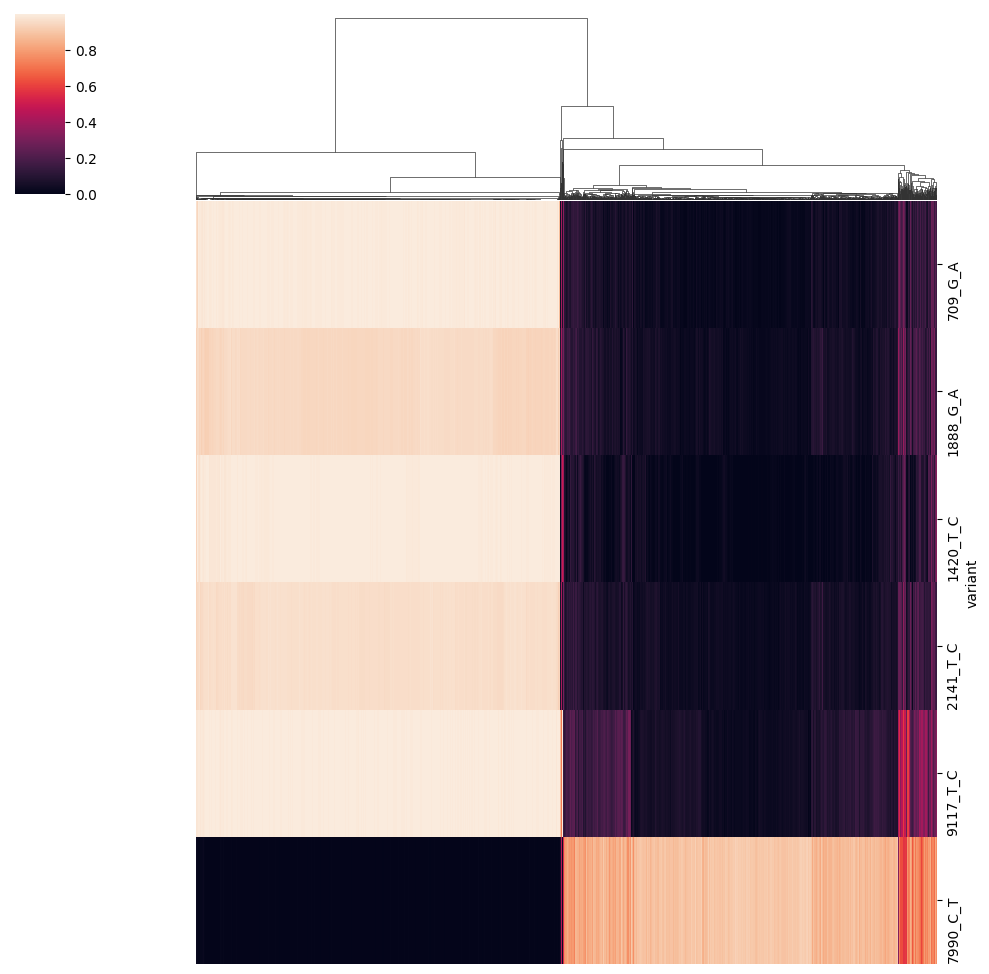

In [23]:
g=sns.clustermap(mixing_heteroplasmy.loc[known_variants],row_cluster=False,xticklabels=False)

In [24]:
col_clusters = fcluster(g.dendrogram_col.linkage, 2, criterion='maxclust')

In [42]:
first_columns  = [c for j,c in enumerate(mixing_heteroplasmy.loc[known_variants].columns) if col_clusters[j]==1]
second_columns  = [c for j,c in enumerate(mixing_heteroplasmy.loc[known_variants].columns) if col_clusters[j]==2]

In [43]:
first_variants = ['709_G_A', '1888_G_A', '1420_T_C', '2141_T_C', '9117_T_C']
second_variants = ['7990_C_T']

In [44]:
# define contamination as sum of heteroplasmy in off diagonal
contamination = compute_contamination(mixing_heteroplasmy,
                                      first_variants, second_variants,
                                      first_columns, second_columns)
contamination

482.1671163592688

In [45]:
relative_contamination  = compute_relative_contamination(mixing_heteroplasmy,
                                      first_variants, second_variants,
                                      first_columns, second_columns)
relative_contamination

0.05974695279772988

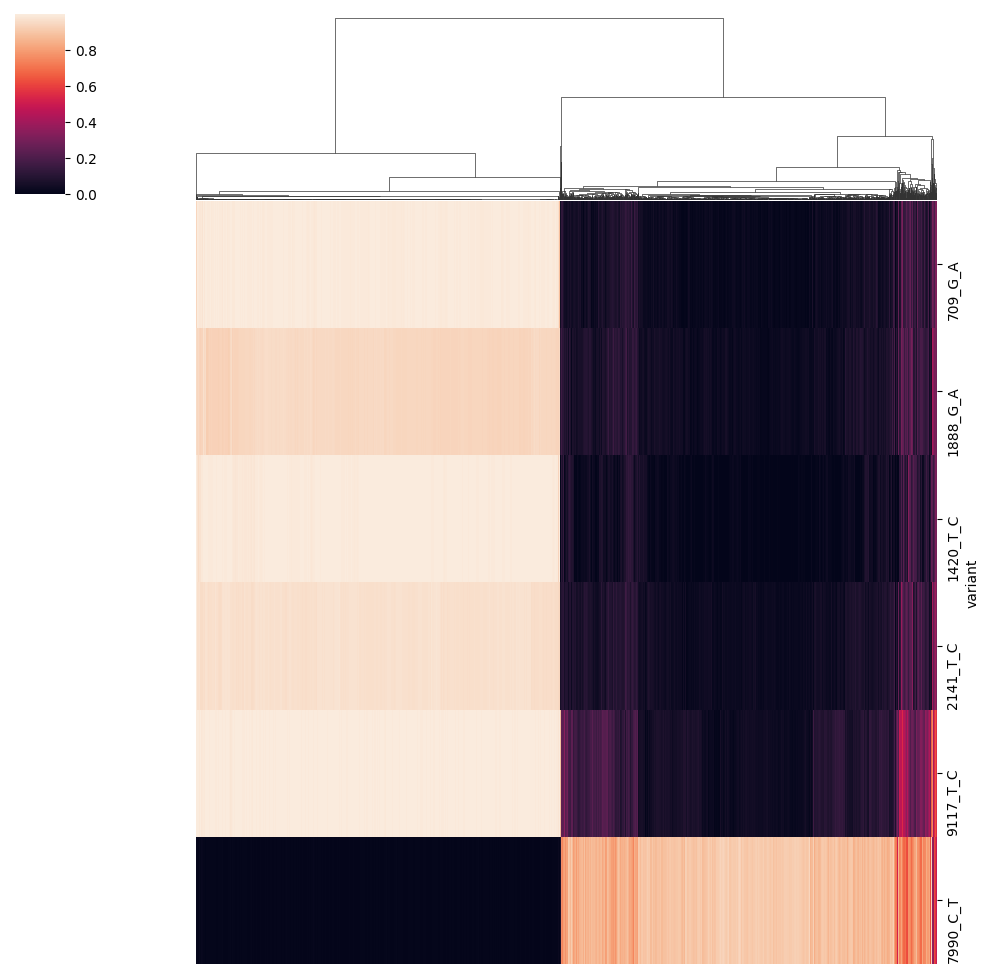

In [35]:
g2 = sns.clustermap(mixing_quality_heteroplasmy.loc[known_variants],row_cluster=False,xticklabels=False)

In [36]:
col_clusters2 = fcluster(g2.dendrogram_col.linkage, 2, criterion='maxclust')
np.shape(col_clusters2)

(2664,)

In [46]:
first_columns2  = [c for j,c in enumerate(mixing_quality_heteroplasmy.loc[known_variants].columns) if col_clusters2[j]==1]
second_columns2  = [c for j,c in enumerate(mixing_quality_heteroplasmy.loc[known_variants].columns) if col_clusters2[j]==2]


In [47]:
# define contamination as sum of heteroplasmy in off diagonal
contamination_quality = compute_contamination(mixing_quality_heteroplasmy,
                                      first_variants, second_variants,
                                      first_columns2, second_columns2)
contamination_quality

479.0460466541597

In [48]:
relative_contamination_quality  = compute_relative_contamination(mixing_quality_heteroplasmy,
                                      first_variants, second_variants,
                                      first_columns2, second_columns2)
relative_contamination_quality

0.059295946296044136

Text(0, 0.5, 'Contamination')

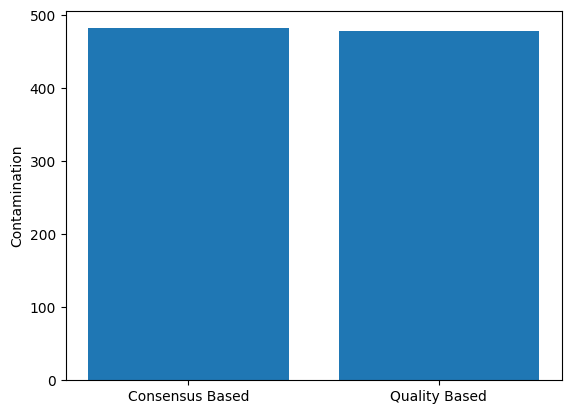

In [51]:
plt.bar(['Consensus Based', 'Quality Based'],[contamination, contamination_quality])
plt.ylabel('Contamination')

Text(0, 0.5, 'Contamination')

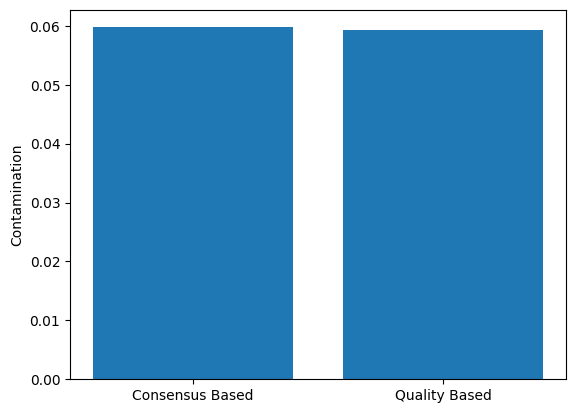

In [52]:
plt.bar(['Consensus Based', 'Quality Based'],[relative_contamination, relative_contamination_quality])
plt.ylabel('Contamination')